# 0.Setup

In [1]:
from google.colab import drive 
drive.mount("/content/gdrive", force_remount = True)

Mounted at /content/gdrive


In [2]:
%cd "/content/gdrive/MyDrive/BME/TA/AI4Healthcare-sem1-2021-2022/TA-sessions/Ses-3"

/content/gdrive/MyDrive/BME/TA/AI4Healthcare-sem1-2021-2022/TA-sessions/Ses-3


### 1.Dataset

In [4]:
!ls Dataset/small_chest_xray

train  val


In [5]:
!ls Dataset/small_chest_xray/train

NORMAL	PNEUMONIA


In [18]:
import os 
import cv2
import matplotlib.pyplot as plt

In [15]:
train_path = os.path.join("Dataset", "small_chest_xray", "train")
normal_train_path = os.path.join(train_path, "NORMAL")
pneumonia_train_path = os.path.join(train_path, "PNEUMONIA")

In [17]:
list_normal_train_imgs = os.listdir(normal_train_path)
list_pneumonia_train_imgs = os.listdir(pneumonia_train_path)

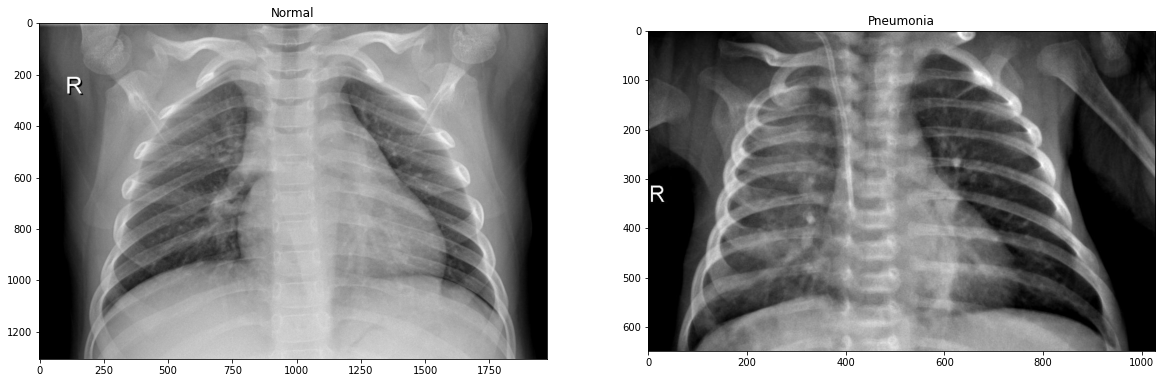

In [24]:
normal_img = cv2.imread(os.path.join(normal_train_path, list_normal_train_imgs[0]))
pneumonia_img = cv2.imread(os.path.join(pneumonia_train_path, list_pneumonia_train_imgs[0]))

normal_img = cv2.cvtColor(normal_img, cv2.COLOR_BGR2RGB)
pneumonia_img = cv2.cvtColor(pneumonia_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (20,10))
ax1 = plt.subplot(1, 2, 1)
ax1.imshow(normal_img)
ax1.title.set_text("Normal")
ax2 = plt.subplot(1, 2, 2)
ax2.imshow(pneumonia_img)
ax2.title.set_text("Pneumonia")
plt.show()

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [26]:
input_shape = (512, 512)

In [53]:
train_datagen = ImageDataGenerator(rescale= 1./255,
                                   shear_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale= 1./255)

In [54]:
training_set = train_datagen.flow_from_directory("Dataset/small_chest_xray/train",
                                                 target_size = input_shape,
                                                 batch_size = 8)
val_set = test_datagen.flow_from_directory("Dataset/small_chest_xray/val",
                                            target_size = input_shape,
                                            batch_size = 8)

Found 112 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


### 2. Create Model

In [25]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
import tensorflow as tf
from tensorflow.keras import Model

In [29]:
def create_model(input_shape, output_shape):
  input = Input(shape = input_shape)
  x = Conv2D(filters = 32, kernel_size = (2,2), activation = "relu", padding = "valid")(input)
  x = MaxPooling2D(pool_size = (2,2))(x)
  
  x = Conv2D(filters = 64, kernel_size = (2,2), activation = "relu", padding = "valid")(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  
  x = Flatten()(x)
  x = Dense(units = 32, activation = "relu")(x)
  
  output = Dense(units = 1, activation = "sigmoid")(x)
  
  return Model(input, output)

In [72]:
model = create_model((512, 512, 3), output_shape = 1)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 512, 512, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 511, 511, 32)      416       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 255, 255, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 254, 254, 64)      8256      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 64)     0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1032256)           0   

In [73]:
model.compile(optimizer= "adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [74]:
callback = [EarlyStopping(monitor= "val_loss", patience= 5),
            ModelCheckpoint("CNN_images_classification.h5", save_best_only = True)]

In [75]:
history = model.fit(training_set, steps_per_epoch= len(training_set),
                    epochs = 20,
                    validation_data = val_set,
                    validation_steps = len(val_set),
                    callbacks = callback)

Epoch 1/20
14/14 [==============================] - 14s 997ms/step - loss: 4.4035 - accuracy: 0.5000 - val_loss: 0.7422 - val_accuracy: 0.5000
Epoch 2/20
14/14 [==============================] - 11s 771ms/step - loss: 0.6994 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/20
14/14 [==============================] - 9s 644ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 4/20
14/14 [==============================] - 12s 833ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/20
14/14 [==============================] - 11s 761ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/20
14/14 [==============================] - 11s 757ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/20
14/14 [==============================] - 11s 755ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000


### 3. Using pretrain model - [tutorial](https://www.tensorflow.org/guide/keras/transfer_learning)

In [39]:
from tensorflow.keras.applications.resnet import ResNet50

In [66]:
resnet50 = ResNet50(input_shape = (512, 512, 3), include_top = False)

In [67]:
# change top of model 
# Create new model on top.
inputs = Input(shape=(512, 512, 3))
x = resnet50(inputs, training = True)
x = Flatten()(x)
x = Dense(units = 64, activation = "relu")(x)
outputs = Dense(units = 1, activation = "sigmoid")(x)
resnet50 = Model(inputs, outputs)

In [68]:
resnet50.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 512, 512, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 16, 16, 2048)      23587712  
                                                                 
 flatten_2 (Flatten)         (None, 524288)            0         
                                                                 
 dense_7 (Dense)             (None, 64)                33554496  
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 57,142,273
Trainable params: 57,089,153
Non-trainable params: 53,120
_________________________________________________________________


In [69]:
callback = [EarlyStopping(monitor= "val_loss", patience= 5),
            ModelCheckpoint("pre_train_CNN_images_classification.h5", save_best_only = True)]

In [70]:
resnet50.compile(optimizer= "adam",
                 loss = "binary_crossentropy",
                 metrics = ["accuracy"])

In [71]:
history = resnet50.fit(training_set, steps_per_epoch= len(training_set),
                      epochs = 20,
                      validation_data = val_set,
                      validation_steps = len(val_set),
                      callbacks = callback)

Epoch 1/20
14/14 [==============================] - ETA: 0s - loss: 20.0432 - accuracy: 0.5000

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


14/14 [==============================] - 57s 2s/step - loss: 20.0432 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/20
14/14 [==============================] - 15s 1s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/20
14/14 [==============================] - 15s 1s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/20
14/14 [==============================] - 14s 981ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/20
14/14 [==============================] - 14s 980ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/20
14/14 [==============================] - 24s 2s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/20
14/14 [==============================] - 15s 1s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 8/20
14/14 [======

In [76]:
!ls

1.How-to-connect-Google-Colab
2.KNN_Classification_Structure_Data.KNN_Classification
3.ANN_Structure_Data
4.UNet_Segmentation
5.CNN_images_classification
best_model_ANN.h5
bestmodel.h5
Checkpoint_Unet_dice.h5
Checkpoint_Unet_normal.h5
CNN_images_classification.h5
Dataset
KNN_Classification_model.pkl
pre_train_CNN_images_classification.h5
